# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/electricity.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/electricity.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

The dataset contains electricity consumption (in kWh) from 321 clients (nodes), recorded every 15 minutes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Columns: 321 entries, 0 to 320
dtypes: float64(321)
memory usage: 64.4 MB


In [ ]:
(26303*15/60)

6575.75

In [ ]:
365*24

8760

In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


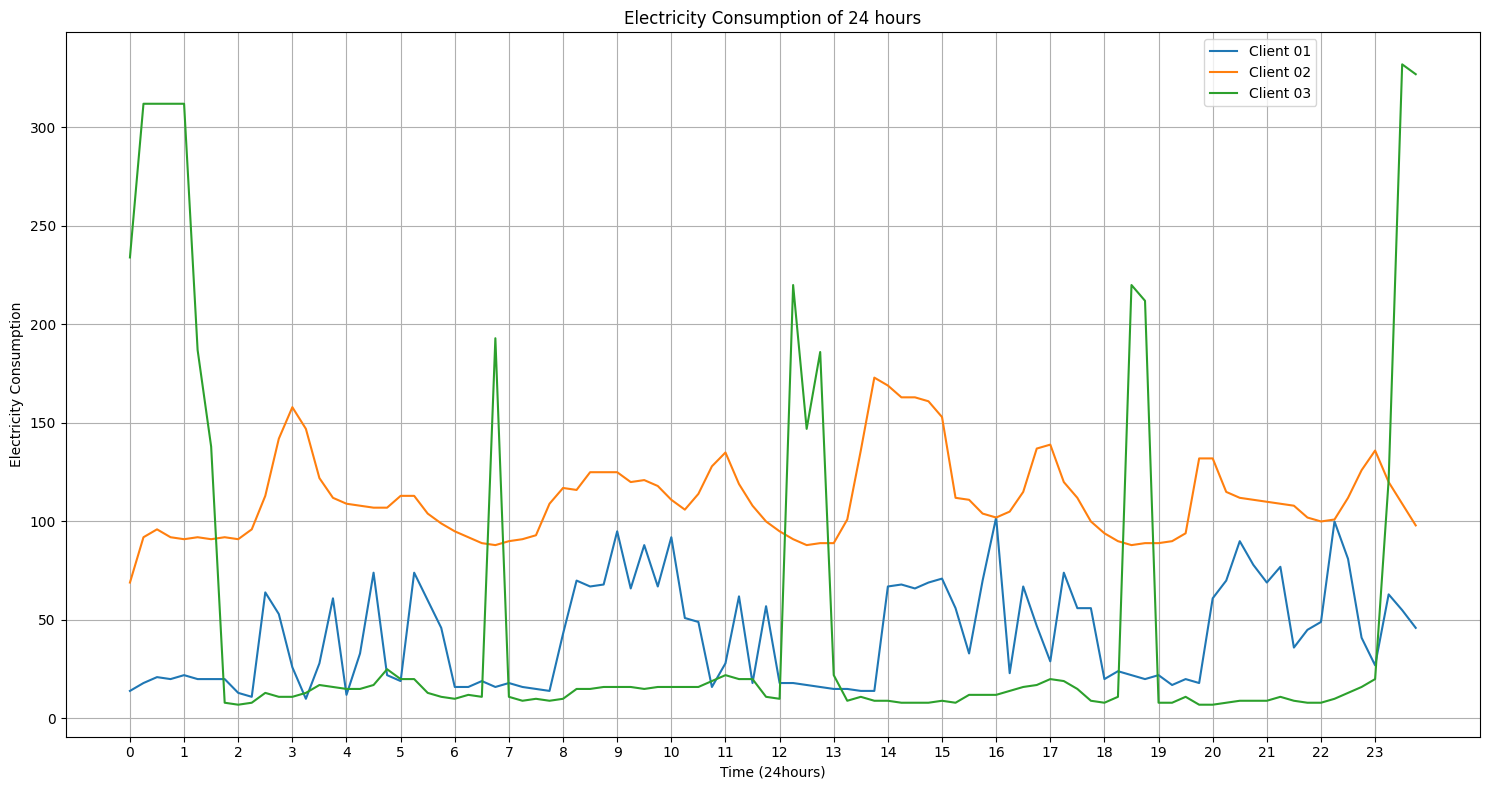

In [ ]:
# Visualizations for Electricity Dataset (15-min interval)

plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:96, 0])
plt.plot(df.iloc[:96, 1])
plt.plot(df.iloc[:96, 2])
plt.title('Electricity Consumption of 24 hours')
plt.xlabel('Time (24hours)')
plt.ylabel('Electricity Consumption')
plt.grid(True)
ticks = np.arange(0, 96, 4)  # 0,4,8,...,92
labels = np.arange(0, 24, 1)  # 0 to 23 hours
plt.xticks(ticks, labels)
plt.tight_layout()
plt.legend(['Client 01', 'Client 02', 'Client 03'],
           loc='upper left', bbox_to_anchor=(0.8, 1))
plt.show()


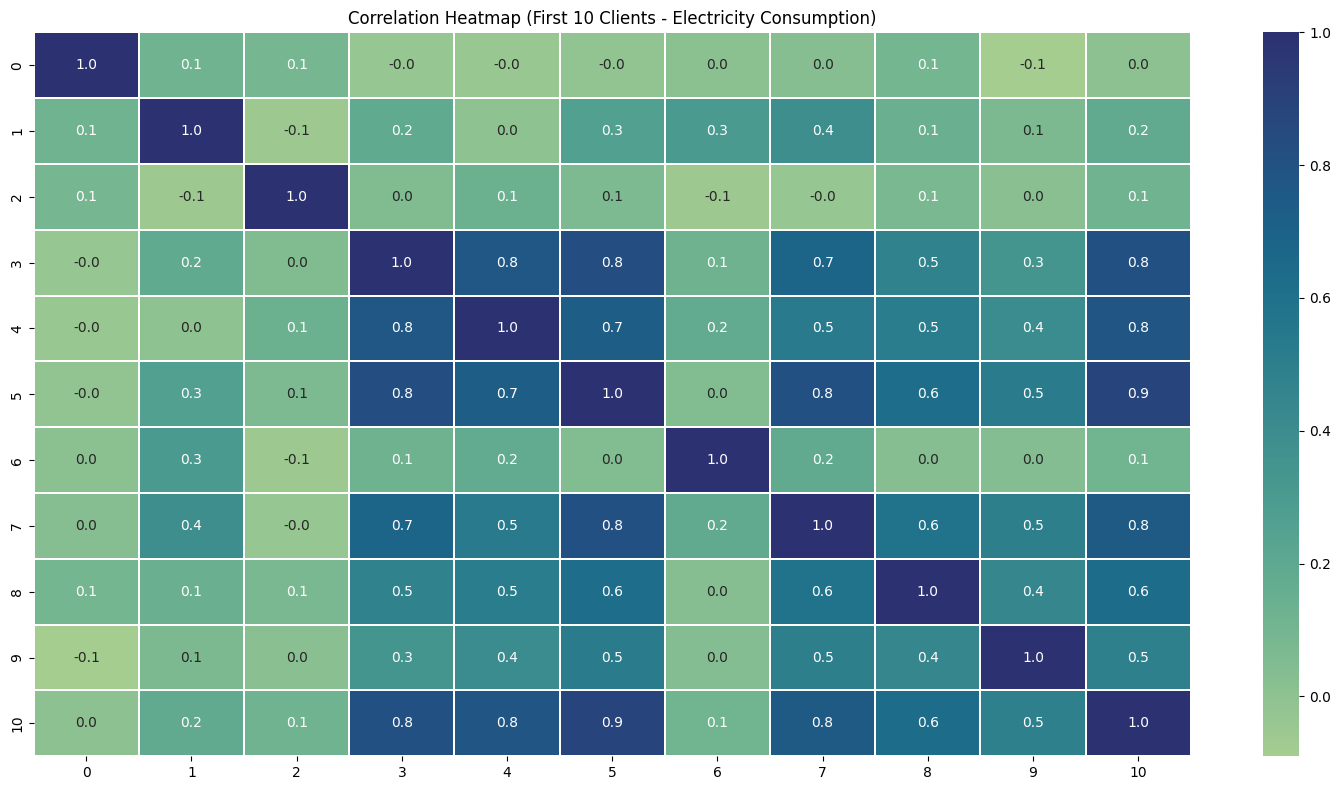

In [ ]:
correlation_subset = df.iloc[:, :11].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='.1f')
plt.title('Correlation Heatmap (First 10 Clients - Electricity Consumption)')
plt.tight_layout()
plt.show()

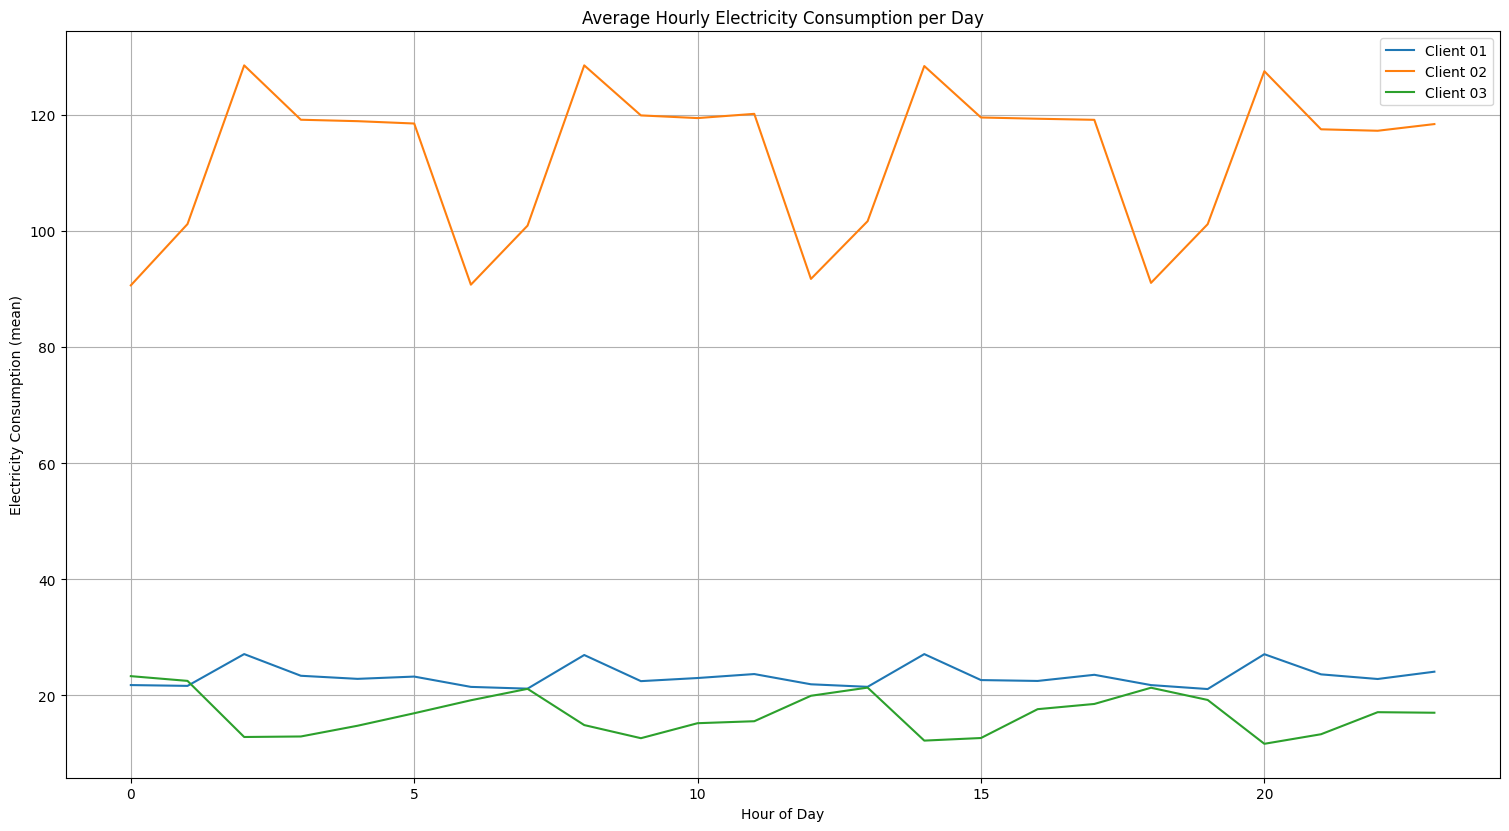

In [ ]:
# Calculate hour from index (96 steps per day, 4 steps per hour)
df['hours'] = (df.index % 96) // 4

plt.figure(figsize=(15, 8))
plt.plot(df.groupby(by='hours')[[0,1,2]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hour of Day')
plt.ylabel('Electricity Consumption (mean)')
plt.title('Average Hourly Electricity Consumption per Day')
plt.legend(['Client 01', 'Client 02', 'Client 03'])
plt.show()


In [ ]:
# Create datetime index for the dataset (15-min intervals)
date_range = pd.date_range(start='2012-01-01', periods=len(df), freq='15min')
df['month'] = date_range.month


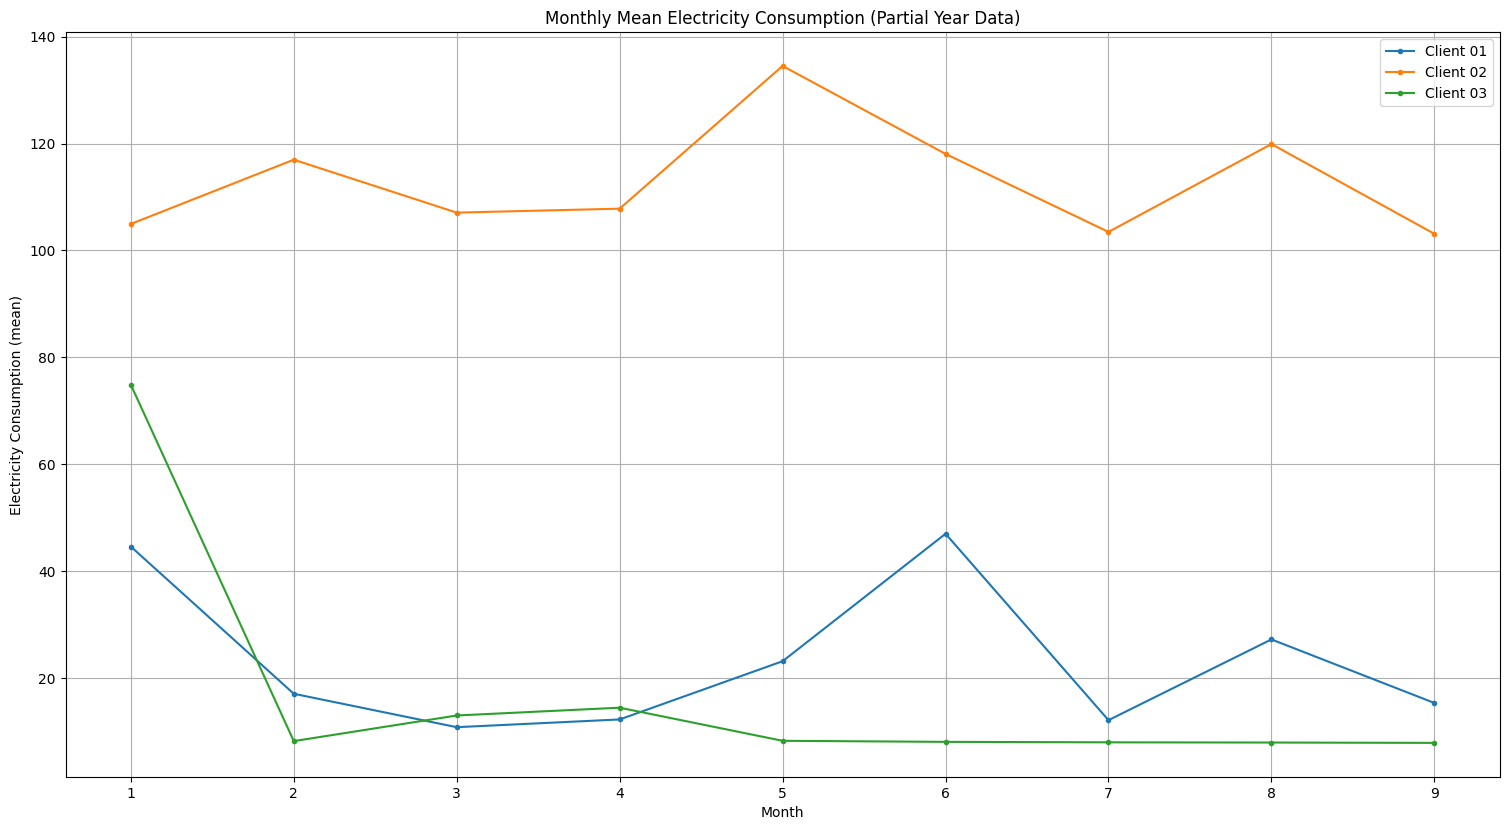

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

plt.figure(figsize=(15, 8))
plt.plot(monthly_avg, marker='.')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Electricity Consumption (mean)')
plt.title('Monthly Mean Electricity Consumption (Partial Year Data)')
plt.legend(['Client 01', 'Client 02', 'Client 03'])
plt.show()


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,26304.0,23.263762,24.127164,0.0,9.00,11.0,24.00,140.0
1,26304.0,112.885569,25.553141,0.0,95.00,113.0,130.00,296.0
2,26304.0,16.821624,49.190377,0.0,8.00,8.0,10.00,601.0
3,26304.0,440.335196,152.601050,0.0,334.75,400.0,511.00,1170.0
4,26304.0,200.536724,69.727348,0.0,148.00,190.0,239.00,547.0
...,...,...,...,...,...,...,...,...
318,26304.0,2264.188641,545.279372,0.0,1999.00,2319.0,2607.00,4449.0
319,26304.0,507.008858,267.445473,0.0,233.00,504.0,704.00,1369.0
320,26304.0,3335.883744,552.754335,0.0,2920.00,3271.0,3632.00,6035.0
hours,26304.0,11.500000,6.922318,0.0,5.75,11.5,17.25,23.0


In [ ]:
sample_clients = df.columns[:5]
# df[sample_clients].iloc[:500].plot(figsize=(15,6))
# plt.title('Electricity Consumption for Sample Clients (First 500 steps)')
# plt.show()


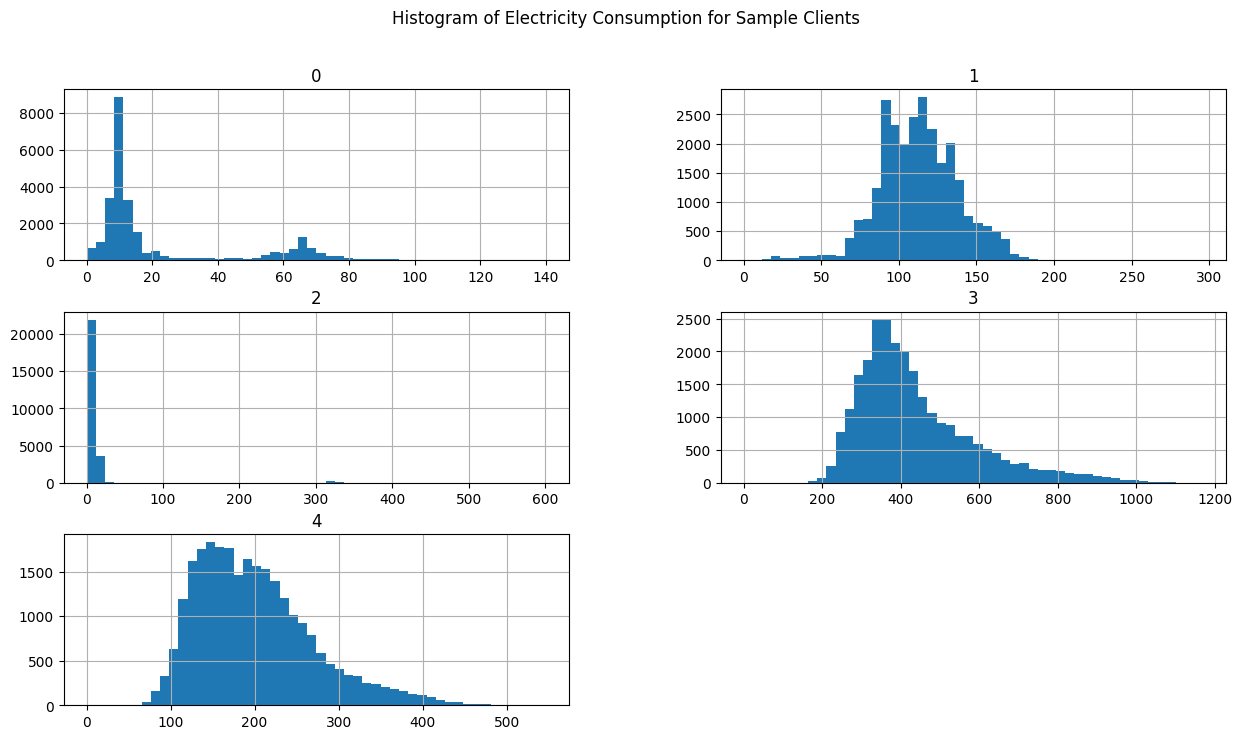

In [ ]:
df[sample_clients].hist(bins=50, figsize=(15,8))
plt.suptitle('Histogram of Electricity Consumption for Sample Clients')
plt.show()


In [ ]:
rolling_mean = df[sample_clients].rolling(window=96).mean()  # daily rolling mean
rolling_std = df[sample_clients].rolling(window=96).std()


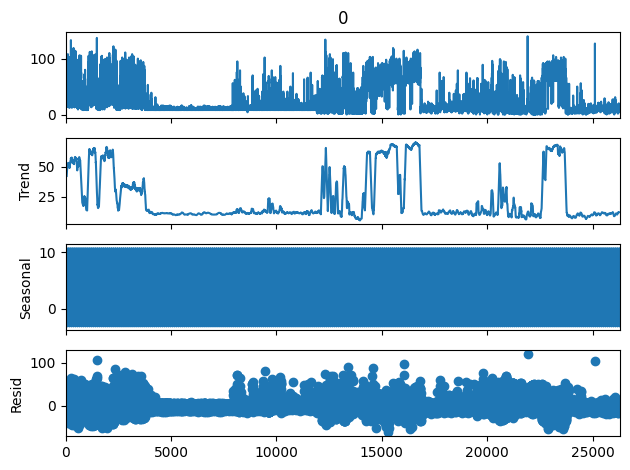

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[sample_clients[0]], model='additive', period=96)
result.plot()
plt.show()


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
# Time split FIRST
split_ratio = 0.7
split_idx = int(len(df) * split_ratio)

df_train_raw = df.iloc[:split_idx]
df_test_raw  = df.iloc[split_idx:]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scaler on TRAIN ONLY
scaler = MinMaxScaler()

df_train = pd.DataFrame(
    scaler.fit_transform(df_train_raw),
    columns=df.columns,
    index=df_train_raw.index
)


# Transform TEST using SAME scaler
df_test = pd.DataFrame(
    scaler.transform(df_test_raw),
    columns=df.columns,
    index=df_test_raw.index
)

In [ ]:
24*60/15

96.0

In [ ]:
#########
window_size = 168
forecast_horizon = 24  # 6 hours
batch_size = 24
n_nodes = df_train.shape[1]

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature=(
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Model: PatchedTalNet

In [ ]:
import tensorflow as tf
import zipfile
import os

In [ ]:
@tf.keras.utils.register_keras_serializable()
class RevIN(tf.keras.layers.Layer):
    def __init__(self, eps=1e-5, affine=True, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        n = int(input_shape[-1])
        if self.affine:
            self.gamma = self.add_weight(
                name="gamma", shape=(1, 1, n),
                initializer="ones", trainable=True
            )
            self.beta = self.add_weight(
                name="beta", shape=(1, 1, n),
                initializer="zeros", trainable=True
            )
        super().build(input_shape)

    def call(self, x, mode, stats=None):
        if mode == "norm":
            mu = tf.reduce_mean(x, axis=1, keepdims=True)
            sigma = tf.math.reduce_std(x, axis=1, keepdims=True)
            x_hat = (x - mu) / (sigma + self.eps)
            if self.affine:
                x_hat = x_hat * self.gamma + self.beta
            return x_hat, (mu, sigma)

        elif mode == "denorm":
            mu, sigma = stats
            x_hat = x
            if self.affine:
                x_hat = (x_hat - self.beta) / (self.gamma + self.eps)
            return x_hat * (sigma + self.eps) + mu

    def get_config(self):
        config = super().get_config()
        config.update({
            "eps": self.eps,
            "affine": self.affine
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_len=16, stride=8, d_model=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.dropout_rate = dropout

        self.dropout = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(d_model)
        self.pos_emb = None

    def build(self, input_shape):
        T = int(input_shape[1])
        n_patches = 1 + (T - self.patch_len) // self.stride

        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, n_patches, self.d_model),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        patches = tf.signal.frame(
            x, frame_length=self.patch_len,
            frame_step=self.stride,
            axis=1
        )

        B = tf.shape(patches)[0]
        n_patches = tf.shape(patches)[1]
        N = tf.shape(patches)[3]

        patches = tf.reshape(patches, [B, n_patches, self.patch_len * N])
        tokens = self.proj(patches)
        tokens = tokens + self.pos_emb
        tokens = self.dropout(tokens, training=training)
        return tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_len": self.patch_len,
            "stride": self.stride,
            "d_model": self.d_model,
            "dropout": self.dropout_rate
        })
        return config

In [ ]:
n_nodes, forecast_horizon

(321, 24)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchedTalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon,
                 patch_len=16, patch_stride=8,
                 d_model=128, n_heads=8, n_stack=2,
                 dropout_rate=0.2,
                 pool_lstm_units=None,
                 **kwargs):
        super().__init__(**kwargs)

        self.n_nodes = n_nodes
        self.horizon = horizon
        self.patch_len = patch_len
        self.patch_stride = patch_stride
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.pool_lstm_units = pool_lstm_units

        self.revin = RevIN()

        self.patch = PatchEmbedding(
            patch_len=patch_len,
            stride=patch_stride,
            d_model=d_model,
            dropout=dropout_rate
        )

        key_dim = max(8, d_model // n_heads)

        self.blocks = []
        for _ in range(n_stack):
            self.blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(
                    num_heads=n_heads,
                    key_dim=key_dim,
                    dropout=dropout_rate
                ),
                "drop1": tf.keras.layers.Dropout(dropout_rate),
                "add1": tf.keras.layers.Add(),
                "norm1": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(4 * d_model, activation="relu"),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(d_model),
                ]),
                "drop2": tf.keras.layers.Dropout(dropout_rate),
                "add2": tf.keras.layers.Add(),
                "norm2": tf.keras.layers.LayerNormalization(),
            })

        units = pool_lstm_units if pool_lstm_units else (d_model // 2)

        self.pool = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units,
                return_sequences=False,
                dropout=dropout_rate * 0.7
            )
        )

        self.out_drop = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x, training=None):

        x, stats = self.revin(x, mode="norm")
        h = self.patch(x, training=training)

        for b in self.blocks:
            attn = b["attn"](h, h, training=training)
            attn = b["drop1"](attn, training=training)
            h = b["add1"]([h, attn])
            h = b["norm1"](h)

            ffn = b["ffn"](h, training=training)
            ffn = b["drop2"](ffn, training=training)
            h = b["add2"]([h, ffn])
            h = b["norm2"](h)

        # Moved outside loop (important!)
        z = self.pool(h, training=training)
        z = self.out_drop(z, training=training)

        y = self.fc(z)
        y = tf.reshape(y, [-1, self.horizon, self.n_nodes])
        y = self.revin(y, mode="denorm", stats=stats)

        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "horizon": self.horizon,
            "patch_len": self.patch_len,
            "patch_stride": self.patch_stride,
            "d_model": self.d_model,
            "n_heads": self.n_heads,
            "n_stack": self.n_stack,
            "dropout_rate": self.dropout_rate,
            "pool_lstm_units": self.pool_lstm_units,
        })
        return config

In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=16,
    patch_stride=8,
    d_model=64,
    n_heads=4,
    n_stack=2,
    dropout_rate=0.2
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    clipnorm=1.0),
    loss="mse",
    metrics=["mae"]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
    760/Unknown 55s 53ms/step - loss: 0.0150 - mae: 0.0940

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


760/760 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - loss: 0.0150 - mae: 0.0939 - val_loss: 0.0061 - val_mae: 0.0519
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 63s 46ms/step - loss: 0.0066 - mae: 0.0553 - val_loss: 0.0057 - val_mae: 0.0491
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step - loss: 0.0062 - mae: 0.0531 - val_loss: 0.0052 - val_mae: 0.0479
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step - loss: 0.0056 - mae: 0.0516 - val_loss: 0.0047 - val_mae: 0.0459
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - loss: 0.0052 - mae: 0.0500 - val_loss: 0.0045 - val_mae: 0.0450
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0050 - mae: 0.0491 - val_loss: 0.0043 - val_mae: 0.0441
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0049 - mae: 0.0486 - val_loss: 0.0042 - val_mae: 0.0436
Epoch 8/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0048 - mae: 0.0480 - val_loss: 0.0042 - val_mae: 0.0431
Epoch 9/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 35s

# Evaluations

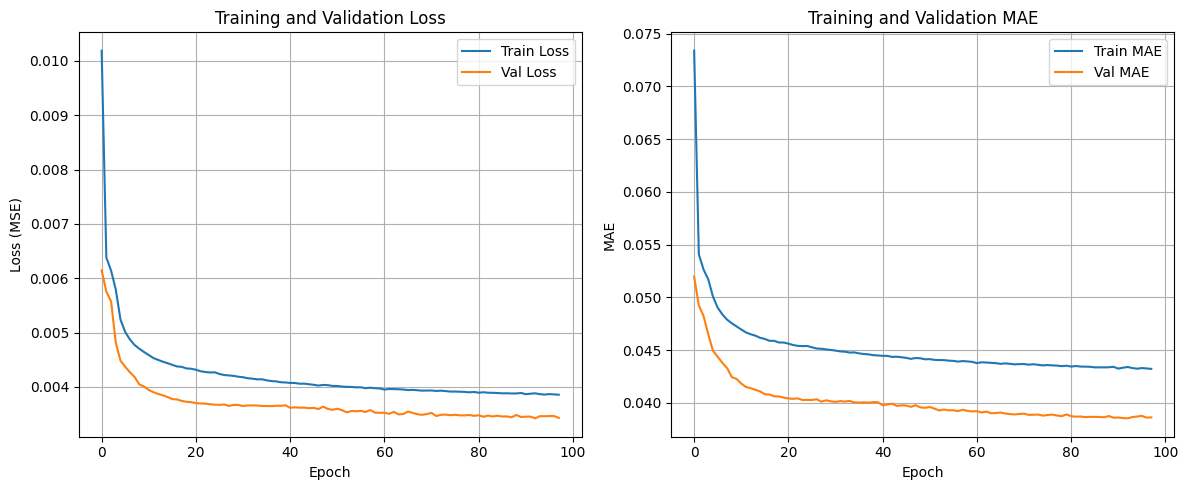

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)


In [ ]:
y_pred = model.predict(test_dataset)

321/321 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(f'Model Name: Patched TalNet')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")

Model Name: Patched TalNet
Step  3 --> R²=0.9159, RMSE=0.0567, MAE=0.0375, MSE=0.0032, SMAPE=13.61%, RSE=0.2900, CORR=0.9571
Step  6 --> R²=0.9148, RMSE=0.0571, MAE=0.0377, MSE=0.0033, SMAPE=13.67%, RSE=0.2918, CORR=0.9565
Step 12 --> R²=0.9135, RMSE=0.0575, MAE=0.0380, MSE=0.0033, SMAPE=13.73%, RSE=0.2941, CORR=0.9558
Step 24 --> R²=0.9111, RMSE=0.0583, MAE=0.0384, MSE=0.0034, SMAPE=13.82%, RSE=0.2982, CORR=0.9545


 ## Plots after model trained

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

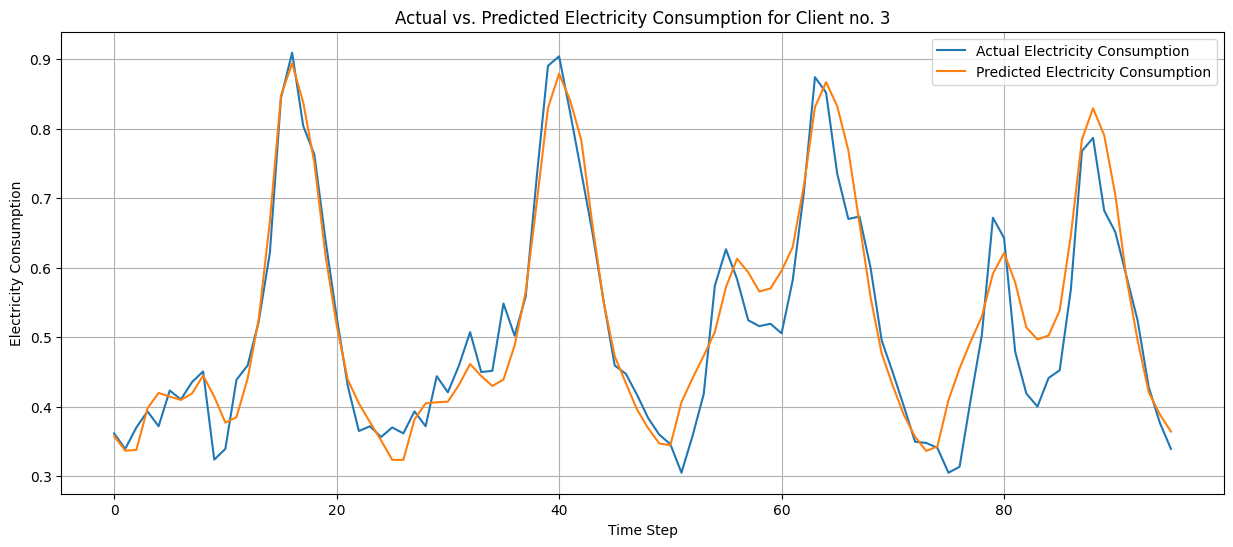

In [ ]:
# Actual Vs Predicted COnsumption Curve

sample_node = 3
sample_time_steps = 96

plt.figure(figsize=(15, 6))
plt.plot(y_test[:sample_time_steps, 0, sample_node], label='Actual Electricity Consumption')
plt.plot(y_pred[:sample_time_steps, 0, sample_node], label='Predicted Electricity Consumption')
plt.title(f'Actual vs. Predicted Electricity Consumption for Client no. {sample_node}')
plt.xlabel('Time Step')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid(True)
plt.show()

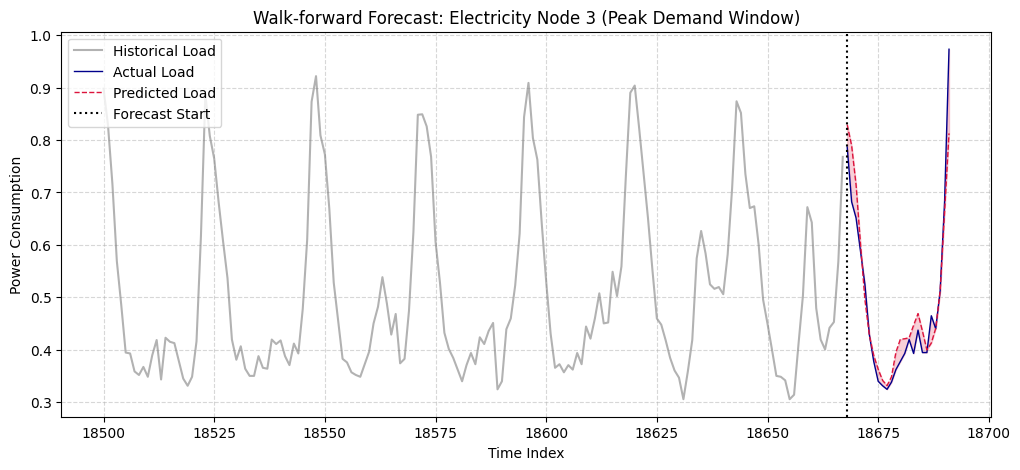

In [ ]:
# Walk-forward Forecast

node_idx = 3
peak_window_idx = np.argmax(np.max(y_test[:, :, node_idx], axis=1))

context_start = peak_window_idx
context_end = peak_window_idx + window_size
forecast_start = context_end
forecast_end = context_end + forecast_horizon

plt.figure(figsize=(12, 5))

plt.plot(df_test.index[context_start:context_end],
         df_test.iloc[context_start:context_end, node_idx],
         label='Historical Load', color='gray', alpha=0.6)

forecast_index = df_test.index[forecast_start:forecast_end]
actual_vals = y_test[peak_window_idx, :, node_idx].flatten()
pred_vals = y_pred[peak_window_idx, :, node_idx].flatten()

plt.plot(forecast_index, actual_vals, label='Actual Load', color='darkblue', linewidth=1)
plt.plot(forecast_index, pred_vals, label='Predicted Load', color='crimson', linestyle='--', linewidth=1)

plt.axvline(x=df_test.index[forecast_start], color='black', linestyle=':', label='Forecast Start')
plt.fill_between(forecast_index, actual_vals, pred_vals, color='crimson', alpha=0.2)

plt.title(f'Walk-forward Forecast: Electricity Node {node_idx} (Peak Demand Window)')
plt.xlabel('Time Index')
plt.ylabel('Power Consumption')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

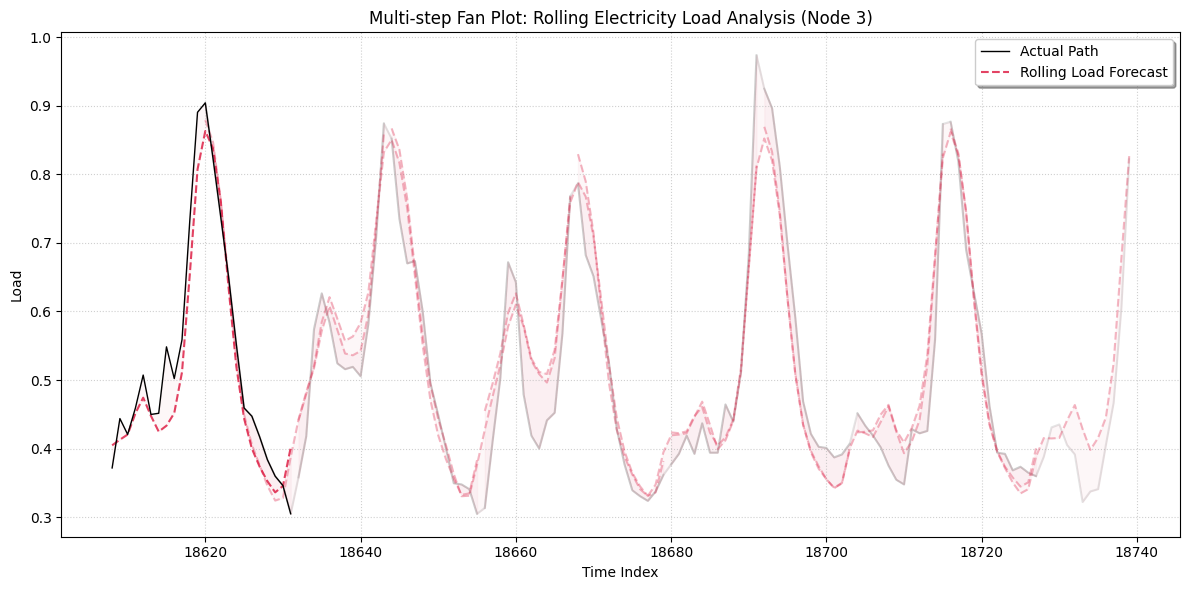

In [ ]:
# Multi-step Fan Plot

node_idx = 3
n_forecasts = 10
step_size = forecast_horizon // 2

plt.figure(figsize=(12, 6))

start_offset = np.argmax(np.max(y_test[:, :, node_idx], axis=1)) - (n_forecasts * step_size // 2)

for i in range(n_forecasts):
    win_idx = start_offset + (i * step_size)

    forecast_idx = df_test.index[win_idx + window_size : win_idx + window_size + forecast_horizon]
    actual_vals = y_test[win_idx, :, node_idx].flatten()
    pred_vals = y_pred[win_idx, :, node_idx].flatten()

    if i == 0:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=1, label='Actual Path', zorder=10)
        plt.plot(forecast_idx, pred_vals, color='crimson', alpha=0.8, linestyle='--', label='Rolling Load Forecast', zorder=5)
    else:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=1.5, alpha=0.1, zorder=1)
        plt.plot(forecast_idx, pred_vals, color='crimson', alpha=0.3, linestyle='--', zorder=5)

    plt.fill_between(forecast_idx, actual_vals, pred_vals, color='crimson', alpha=0.03)

plt.title(f'Multi-step Fan Plot: Rolling Electricity Load Analysis (Node {node_idx})')
plt.xlabel('Time Index')
plt.ylabel('Load')
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

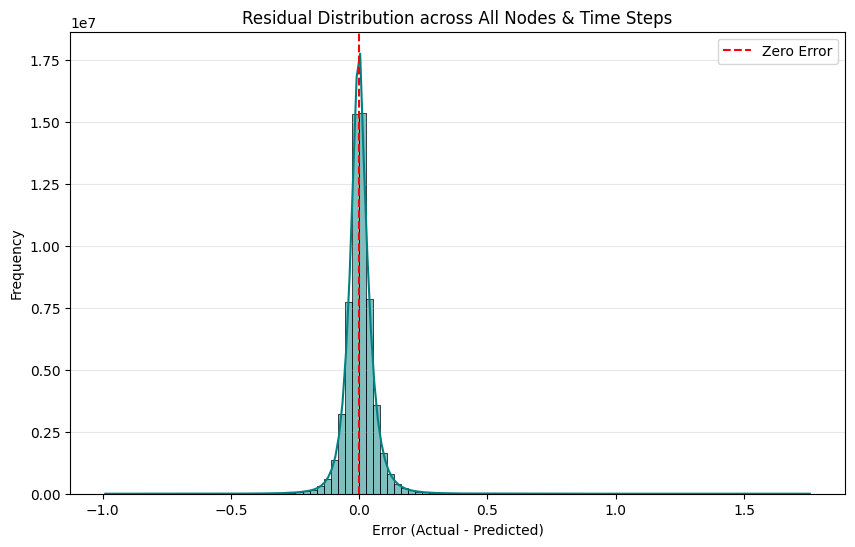

Mean Residual: 0.0013
Residual Std Dev: 0.0583


In [ ]:
# Residual Distribution

residuals = (y_test - y_pred).flatten()
plt.figure(figsize=(10, 6))

# Plotting the distribution with a Kernel Density Estimate (KDE)
sns.histplot(residuals, kde=True, color='teal', bins=100)

# Add a vertical line at 0 to show the perfect prediction center
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')

plt.title('Residual Distribution across All Nodes & Time Steps')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print basic residual statistics
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Std Dev: {np.std(residuals):.4f}")


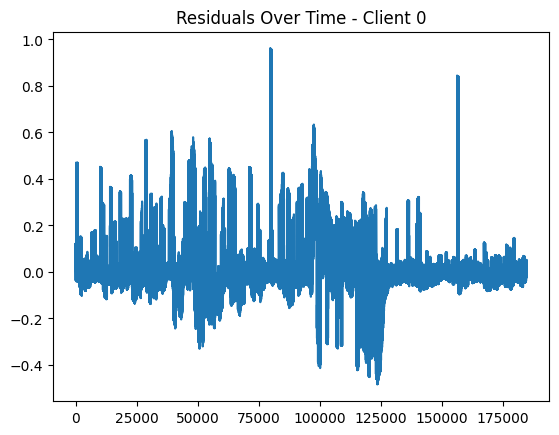

In [ ]:
plt.plot(residuals[:, :, 0].flatten())
plt.title('Residuals Over Time - Client 0')
plt.show()

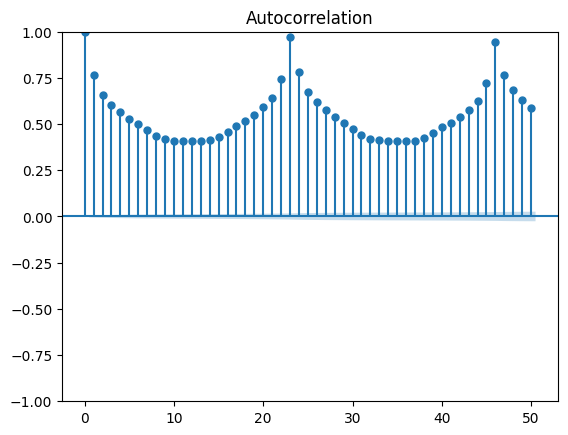

In [ ]:
# Residual Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals[:, :, 0].flatten(), lags=50)
plt.show()

In [ ]:
y_test.shape[2]

321

# Model Saving

In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_electricity.keras"
model.save(save_dir)  # saves in SavedModel format
print(f"Model saved successfully at {save_dir}")

Model saved successfully at /content/drive/MyDrive/data/varsity/PatchedTalNet_electricity.keras


In [ ]:
model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully
